In [1]:
!pip install nltk==3.6.5
!pip install sklearn==0.0

     |████████████████████████████████| 1.5 MB 1.5 MB/s            
     |████████████████████████████████| 763 kB 11.9 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1309 sha256=1bf3e2c22329f4c6d156e69c14468b4fb7120822be12395629724736c009d279
  Stored in directory: /home/jovyan/.cache/pip/wheels/e4/7b/98/b6466d71b8d738a0c547008b9eb39bf8676d1ff6ca4b22af1c
Successfully built sklearn


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType
import string
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from pyspark.sql.functions import percent_rank
from pyspark.sql import Window
from pyspark.ml.feature import CountVectorizer, IDF, Tokenizer

In [3]:
spark = SparkSession \
    .builder \
    .getOrCreate()
print(spark)

:: loading settings :: url = jar:file:/usr/local/spark-3.2.0-bin-hadoop3.2/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/jovyan/.ivy2/cache
The jars for the packages stored in: /home/jovyan/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-39cb8b5b-c799-4963-9f58-e9ebc6bb29fb;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 in central
	found org.mongodb#mongodb-driver-sync;4.0.5 in central
	found org.mongodb#bson;4.0.5 in central
	found org.mongodb#mongodb-driver-core;4.0.5 in central
downloading https://repo1.maven.org/maven2/org/mongodb/spark/mongo-spark-connector_2.12/3.0.1/mongo-spark-connector_2.12-3.0.1.jar ...
	[SUCCESSFUL ] org.mongodb.spark#mongo-spark-connector_2.12;3.0.1!mongo-spark-connector_2.12.jar (197ms)
downloading https://repo1.maven.org/maven2/org/mongodb/mongodb-driver-sync/4.0.5/mongodb-driver-sync-4.0.5.jar ...
	[SUCCESSFUL ] org.mongodb#mongodb-driver-sync;4.0.5!mongodb-driver-sync.jar (62ms)
downloading https://repo1.maven.org

In [4]:
crypto_df = spark.read.format("mongo").option("uri","mongodb://mongo/seng550.crypto").load()
crypto_df.show()
headers_df = spark.read.format("mongo").option("uri","mongodb://mongo/seng550.headers").load()
headers_df.show()

+--------------------+------------------+----------+------------------+
|                 _id|             close|      date|              open|
+--------------------+------------------+----------+------------------+
|{619f20a05fec62ac...|        61238.6222|2021-10-23| 60690.28731420007|
|{619f20a15fec62ac...| 60694.00000650834|2021-10-22| 62196.96438572152|
|{619f20a15fec62ac...|62298.093007718286|2021-10-21| 65961.04976056097|
|{619f20a15fec62ac...| 65986.30293718613|2021-10-20|        64252.7263|
|{619f20a15fec62ac...|        64217.0839|2021-10-19|        62020.0126|
|{619f20a15fec62ac...|        61953.2331|2021-10-18| 61543.26469764322|
|{619f20a15fec62ac...| 61582.25155249131|2021-10-17| 60867.89483798279|
|{619f20a15fec62ac...| 60860.89183706596|2021-10-16| 61698.03021926293|
|{619f20a15fec62ac...| 61526.33413298988|2021-10-15|57312.383791730215|
|{619f20a15fec62ac...|  57351.7384160736|2021-10-14|        57385.8884|
|{619f20a15fec62ac...|        57357.6067|2021-10-13| 56030.57101

In [5]:
# https://stackoverflow.com/questions/58823628/call-a-function-for-each-row-of-a-dataframe-in-pysparknon-pandas
def get_change(close, open_):
    return  close - open_
spark.udf.register("change_udf", get_change)
# crypto_df.show()
crypto_df = crypto_df.withColumn('change', get_change(col('close'), col('open'))).drop("close","open","_id")
crypto_df.show()

+----------+-------------------+
|      date|             change|
+----------+-------------------+
|2021-10-23|  548.3348857999299|
|2021-10-22|-1502.9643792131828|
|2021-10-21| -3662.956752842685|
|2021-10-20| 1733.5766371861318|
|2021-10-19|  2197.071299999996|
|2021-10-18|  409.9684023567752|
|2021-10-17|   714.356714508518|
|2021-10-16| -837.1383821969721|
|2021-10-15|  4213.950341259668|
|2021-10-14|   -34.149983926407|
|2021-10-13| 1327.0356888160168|
|2021-10-12|-1363.3682153036207|
|2021-10-11|   2703.30516992879|
|2021-10-10|-236.60011243464396|
|2021-10-09|  1139.973213752317|
|2021-10-08| 111.23452299229393|
|2021-10-07|-1506.7725035558396|
|2021-10-06|  3885.388159487484|
|2021-10-05|  2271.338468076465|
|2021-10-04|   990.114499999996|
+----------+-------------------+
only showing top 20 rows



In [6]:
def clean_header(header):
    porter = PorterStemmer()
    # headers are small, so local process is ok
    header = header.strip()
    if not header:
        return ''
    header = header.translate(str.maketrans('', '', string.punctuation))
    return ' '.join(porter.stem(word) for word in header.split() if word not in ENGLISH_STOP_WORDS)
udf_clean_header = udf(lambda s: clean_header(s), StringType())
headers_df = headers_df.withColumn('headline_clean', udf_clean_header(col('headline')))
headers_df.show()

+--------------------+----------+--------------------+--------------------+
|                 _id|      date|            headline|      headline_clean|
+--------------------+----------+--------------------+--------------------+
|{619f1214b82509cf...|2021-08-01|Family speaks out...|famili speak raci...|
|{619f1215b82509cf...|2021-08-01|China invasion of...|china invas taiwa...|
|{619f1215b82509cf...|2021-08-01|US digital paymen...|us digit payment ...|
|{619f1215b82509cf...|2021-08-01|‘Allow Malaysians...|‘allow malaysian ...|
|{619f1215b82509cf...|2021-08-01|Australia's After...|australia afterpa...|
|{619f1215b82509cf...|2021-08-01|Americans blast A...|american blast au...|
|{619f1215b82509cf...|2021-08-01|Turkey fires ‘lik...|turkey fire ‘like...|
|{619f1215b82509cf...|2021-08-01|Horoscope today, ...|horoscop today mo...|
|{619f1215b82509cf...|2021-08-01|Horoscope Today: ...|horoscop today as...|
|{619f1215b82509cf...|2021-08-01|Horoscope Today: ...|horoscop today as...|
|{619f146e97

In [7]:
date_count_df = headers_df.groupby('date').count()
crypto_headline_df = crypto_df.join(headers_df, on='date')\
    .join(date_count_df.withColumnRenamed('count', 'date_count'), on='date')\
    .withColumn('change_normalized', col('change') / col('date_count'))\
    .select('date', 'headline_clean', 'change_normalized')
crypto_headline_df.show()

+----------+--------------------+-------------------+
|      date|      headline_clean|  change_normalized|
+----------+--------------------+-------------------+
|2021-04-06|asian share eas t...|-100.27633574389984|
|2021-04-06|patient wale uk r...|-100.27633574389984|
|2021-04-06|dubai model dodg ...|-100.27633574389984|
|2021-04-06|two deshaun watso...|-100.27633574389984|
|2021-04-06|nasa say photo ra...|-100.27633574389984|
|2021-04-06|arkansa governor ...|-100.27633574389984|
|2021-04-06|derek chauvin tri...|-100.27633574389984|
|2021-04-06|australia accus e...|-100.27633574389984|
|2021-04-06|first covid vacci...|-100.27633574389984|
|2021-04-06|california pacif ...|-100.27633574389984|
|2021-08-30|australian urg sw...|-174.27393000000012|
|2021-08-30|hurrican veteran ...|-174.27393000000012|
|2021-08-30|california nation...|-174.27393000000012|
|2021-08-30|govt doesn’t acce...|-174.27393000000012|
|2021-08-30|whi serena willia...|-174.27393000000012|
|2021-08-30|not singl afghan

In [8]:
# method 1 https://stackoverflow.com/a/51773836, can only be done on 1 partition

# assign ranks
# TODO better method to avoid this problem - if we do random splits it might be better? 
split_rank_df = crypto_headline_df\
    .withColumn("rank", percent_rank().over(Window.partitionBy().orderBy("date")))\
    .drop('date')\
    .cache()
# split
# X_train = df.where("rank <= .8").drop("rank","change")
# X_train.show()
# X_test = df.where("rank > .8").drop("rank","change")
# X_test.show()
# y_train = df.where("rank <= .8").drop("rank","clean_headline")
# y_train.show()
# y_test = df.where("rank > .8").drop("rank","clean_headline")
# y_test.show()
train_df = split_rank_df.where("rank <= .8").drop("rank")
train_df.show()
test_df = split_rank_df.where("rank > .8").drop("rank")
test_df.show()

# method 2 https://stackoverflow.com/a/53193549, needs the number of dates fed in to split
# from pyspark.ml.feature import StringIndexer

# stringIndexer = StringIndexer(inputCol="date", outputCol="index")
# model = stringIndexer.fit(headers_df)
# headers_df = model.transform(headers_df).withColumn("index", col("index").cast("int"))

# headers_df.show()

21/12/18 17:53:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+--------------------+------------------+
|      headline_clean| change_normalized|
+--------------------+------------------+
|black amazon exec...|444.88668289060007|
|jeff bezo versu m...|444.88668289060007|
|michael gudinski ...|444.88668289060007|
|new revolutionari...|444.88668289060007|
|ladi gaga dog wal...|444.88668289060007|
|studi assess caus...|444.88668289060007|
|seahawk qb russel...|444.88668289060007|
|call perman reope...|444.88668289060007|
|an insan blurri t...|444.88668289060007|
|one hin leong fou...|444.88668289060007|
|white hous pull n...|-134.4387735297998|
|is pfizer covid v...|-134.4387735297998|
|hilaria alec bald...|-134.4387735297998|
|gov abbott execut...|-134.4387735297998|
|risk breast cance...|-134.4387735297998|
|texa governor lif...|-134.4387735297998|
|covid19 vaccin al...|-134.4387735297998|
|report suggest ro...|-134.4387735297998|
|who is meghan mar...|-134.4387735297998|
|rio tinto chairma...|-134.4387735297998|
+--------------------+------------

In [9]:
class TfidfModel:
    def __init__(self, tokenizer, cv_model, idf_model):
        self.tokenizer = tokenizer
        self.cv_model = cv_model
        self.idf_model = idf_model

tfidf_comp_prefix = 'kfwsxy'

def fit_tfidf_model(df, input_col, output_col):
    tokenizer = Tokenizer(inputCol=input_col, outputCol=f'{tfidf_comp_prefix}_words')
    words_data = tokenizer.transform(df)

    cv = CountVectorizer(inputCol=f'{tfidf_comp_prefix}_words', outputCol=f'{tfidf_comp_prefix}_raw')
    cv_model = cv.fit(words_data)

    featurized_data = cv_model.transform(words_data)

    idf = IDF(inputCol=f'{tfidf_comp_prefix}_raw', outputCol=output_col)
    idf_model = idf.fit(featurized_data)

    return TfidfModel(tokenizer, cv_model, idf_model)

tfidf_model = fit_tfidf_model(train_df, 'headline_clean', 'headline_features')

In [10]:
def tfidf_vectorize(df, tfidf_model):
    words_data = tfidf_model.tokenizer.transform(df)
    featurized_data = tfidf_model.cv_model.transform(words_data)
    res_df = tfidf_model.idf_model.transform(featurized_data)
    return res_df\
        .drop(f'{tfidf_comp_prefix}_words')\
        .drop(f'{tfidf_comp_prefix}_raw').drop('headline_clean')

vectorized_train_df = tfidf_vectorize(train_df, tfidf_model)
vectorized_test_df = tfidf_vectorize(test_df, tfidf_model)

vectorized_train_df.show()
vectorized_test_df.show()

+------------------+--------------------+
| change_normalized|   headline_features|
+------------------+--------------------+
|444.88668289060007|(5604,[229,253,27...|
|444.88668289060007|(5604,[169,843,92...|
|444.88668289060007|(5604,[24,156,228...|
|444.88668289060007|(5604,[2,1093,118...|
|444.88668289060007|(5604,[32,136,143...|
|444.88668289060007|(5604,[48,437,470...|
|444.88668289060007|(5604,[237,546,68...|
|444.88668289060007|(5604,[0,27,362,2...|
|444.88668289060007|(5604,[346,393,87...|
|444.88668289060007|(5604,[328,616,11...|
|-134.4387735297998|(5604,[116,239,32...|
|-134.4387735297998|(5604,[0,4,20,135...|
|-134.4387735297998|(5604,[96,102,145...|
|-134.4387735297998|(5604,[126,140,16...|
|-134.4387735297998|(5604,[9,102,128,...|
|-134.4387735297998|(5604,[30,49,115,...|
|-134.4387735297998|(5604,[0,1,5,220,...|
|-134.4387735297998|(5604,[11,54,149,...|
|-134.4387735297998|(5604,[135,149,41...|
|-134.4387735297998|(5604,[343,1003,1...|
+------------------+--------------

In [11]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression()
lr.setFeaturesCol("headline_features")
lr.setLabelCol("change_normalized")
model = lr.fit(vectorized_train_df)


21/12/18 17:53:13 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
21/12/18 17:53:13 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
21/12/18 17:53:13 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/12/18 17:53:13 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [12]:
summary = model.evaluate(vectorized_train_df)
mae = summary.meanAbsoluteError
rmse = summary.rootMeanSquaredError
print(f'Training results: MAE:{mae:.5f} rMSE:{rmse:.5f}')
summary = model.evaluate(vectorized_test_df)
mae = summary.meanAbsoluteError
rmse = summary.rootMeanSquaredError
print(f'Test results: MAE:{mae:.5f} rMSE:{rmse:.5f}')

Training results: MAE:0.33726 rMSE:4.81186
Test results: MAE:197.88501 rMSE:257.37313


In [13]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np

featuresCol='headline_features'
labelCol='change_normalized'

regParams = np.linspace(1000,3000,101)

lr = LinearRegression(
    elasticNetParam=0,
    featuresCol=featuresCol,
    labelCol=labelCol)

pipeline = Pipeline(stages=[lr])

paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, regParams)\
    .build()

evaluator = RegressionEvaluator(labelCol=labelCol)

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=4,
                          parallelism=8)

cvModel = crossval.fit(vectorized_train_df)

prediction = cvModel.transform(vectorized_test_df)

21/12/18 17:53:51 WARN BlockManager: Asked to remove block broadcast_5636_piece0, which does not exist
21/12/18 17:53:51 WARN BlockManager: Asked to remove block broadcast_5636, which does not exist


In [14]:
prediction.show()

+------------------+--------------------+-------------------+
| change_normalized|   headline_features|         prediction|
+------------------+--------------------+-------------------+
|        -578.66247|(5604,[150,221,38...| 5.1178503398442245|
|        -578.66247|(5604,[7,49,78,15...| -50.09563633744905|
|        -578.66247|(5604,[142,187,27...|-13.250387700247888|
|        -578.66247|(5604,[298,456,14...|  47.49994060159642|
|        -578.66247|(5604,[2,327,778,...| 14.168924804608835|
|        -578.66247|(5604,[0,1,25,49,...|-13.021742978573545|
|        -578.66247|(5604,[14,463,495...| -9.703466922971057|
|        -578.66247|(5604,[5,173,196,...| -23.91646351065781|
|        -578.66247|(5604,[6,30,130,2...| -7.159288646623597|
|        -578.66247|(5604,[150,380,39...|  8.067012303424836|
|-80.53629999999976|(5604,[30,34,46,8...|  45.69135878355988|
|-80.53629999999976|(5604,[275,435,14...|-13.325423725935607|
|-80.53629999999976|(5604,[3,4,19,35,...|   78.4133359987304|
|-80.536

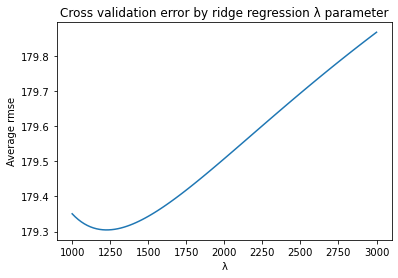

In [15]:
import pandas as pd
x_label = 'λ'
y_label = 'Average ' + evaluator.getMetricName()
tune_result_df = pd.DataFrame({
    x_label: regParams,
    y_label: cvModel.avgMetrics})\
    .set_index(['λ'])
plot = tune_result_df.plot.line(
    title='Cross validation error by ridge regression λ parameter',
    ylabel=y_label,
    legend=False)